In [1]:
%matplotlib inline
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from e11.tools import df_from_dict_of_tuples
from e11.fit import Gaussian

## Generate data

In [2]:
def gauss(x, x0, amp, sigma, offset):
    """ 1D gaussian """
    return amp * np.exp(-0.5 * (((x - x0) / sigma)**2.0)) + offset

# generate 1d data
nx = 500
xvals = np.arange(nx)
arr = []
labels = [-1.2, -0.5, 0.4]
pars = {}
for lbl, x0, amp, sigma in zip(labels, [100, 250, 400], [18, 12, 6], [45, 46, 47]):
    p0 = [x0, amp, sigma, 2]
    pars[lbl] = dict(zip(Gaussian(None, None).vars(), p0))
    yvals = gauss(xvals, *p0) + 1. * np.random.randn(nx)
    arr.append(yvals)
arr = np.array(arr)
pars = pd.DataFrame.from_dict(pars, orient="index")

In [3]:
pars

,x0,amp,sigma,offset
-1.2,100,18,45,2
-0.5,250,12,46,2
0.4,400,6,47,2


## Fit data

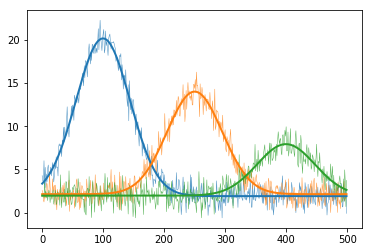

In [4]:
fig, ax = plt.subplots()

best_fit = {}
for lbl, yvals in zip(labels, arr):
    # data
    p = ax.plot(xvals, yvals, lw=0.5, alpha=0.8, zorder=5)
    color = p[0].get_color()
    # fit
    g = Gaussian(xvals, yvals)
    popt, perr = g.fit()
    ax.plot(xvals, g.func(xvals, *popt), color=color, lw=2, zorder=10)
    # record
    best_fit[lbl] = g.asdict()

best_fit = df_from_dict_of_tuples(best_fit)
plt.show()

In [5]:
best_fit

x0                  amp                sigma            \
           value     error      value     error      value     error   
-1.2   99.730079  0.367510  18.224717  0.137878  44.299196  0.411510   
-0.5  249.967479  0.597015  11.853231  0.142019  45.328856  0.683378   
 0.4  399.629869  1.271696   5.954954  0.146154  47.493952  1.442630   

        offset            
         value     error  
-1.2  1.916337  0.055736  
-0.5  2.142752  0.061487  
 0.4  1.970134  0.061571

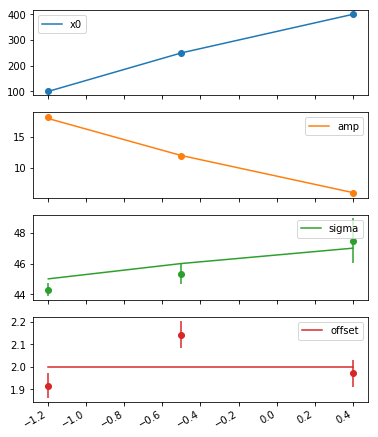

In [6]:
axes = pars.plot(subplots=True, figsize=(6, 8))

for i, var in enumerate(g.vars()):
    yvals = best_fit[(var, "value")]
    yerr = best_fit[(var, "error")]
    axes[i].errorbar(yvals.index, yvals.values, yerr=yerr.values, c="C%d"%i, ls="", marker="o")
plt.show()